In [ ]:
import os
import time
import json

def experiment(request):
    experiment_path = os.path.join(SRC_FOLDER, 'experiment')
    results = {'names': [], 'chunks': [], 'start': [], 'end': [], 'runtimes': []}
    
    audios = os.listdir(os.path.join(experiment_path, 'audio'))
    print(audios)
    for audio_path in audios:
        if (audio_path == 'desktop.ini'):
            continue
        filename = audio_path.rsplit('.', 1)[0]
        print(filename)
        audio_path = os.path.join(experiment_path, 'audio', audio_path)
        print(audio_path)
        title, artist = recognise_audio(audio_path, filename)
        transcript = get_synced_lyrics(title, artist, experiment_path, filename)

        audio = Audio(music=True, artist=artist, title=title, filename=filename, transcript=transcript, 
                coverart_colour="rgb(0, 0, 0)", _ground_truth="null")
        audio.save(True)

        transcript = pylrc.parse(transcript)
        id = 1
        for i in range(len(transcript) - 1):      
            line = transcript[i]
            print(f"Chunk {id}: {line.text}")
            chunk = Chunk.objects.filter(index=id, audio__slug=audio.slug)
            if chunk.exists():
                # print("Updating existing Chunk...")
                chunk.update(text=line.text, audio_id=audio.id, start_time=line.time, end_time=transcript[i+1].time, 
                    _image_ids=chunk[0]._image_ids, _selected_ids=chunk[0]._selected_ids)
                chunk = chunk[0]
            else:
                chunk = Chunk(index=id, text=line.text, audio_id=audio.id, start_time=line.time, 
                    end_time=transcript[i+1].time, _image_ids="[]", _selected_ids="[]")
                chunk.save()
            id += 1
        
        chunks = list(Chunk.objects.filter(audio__slug=audio.slug))
        video_path = os.path.join(experiment_path, 'video', f"{audio.filename}.mp4")
        
        # ----- VIDEO GENERATION RUNTIME EXPERIMENT ------
        results['start'].append(time.time())
        build_video(chunks, clip, audio_path, video_path)
        results['end'].append(time.time())
        # ------------ END OF EXPERIMENT -----------------
        
        results['names'].append(str(audio))
        results['chunks'].append(len(chunks))
        results['runtimes'].append(get_transcript_length(transcript))

        with open(os.path.join(experiment_path, 'resultss', "experiment.json"), "a") as file:
            json.dump(results, file)

    print(results['chunks'])
    print(results['start'])

    return HttpResponse("Experiments Done")

In [2]:
import json
import numpy as np
import random

def total_seconds(time):
    m, s = time.split(':')
    return int(m)*60 + float(s)

def to_time(seconds):
    return f"{int(seconds / 60)}:{seconds % 60:05.2f}"

with open("subset_experiment.json", "r") as results_json:
    results = json.load(results_json)


names = np.array(results['names'])
chunks = np.array(results['chunks'])
generation_times = np.array(results['end']) - np.array(results['start'])
runtimes = np.array(results['runtimes'])
prev_gentimes = np.array([total_seconds(gentime) for gentime in results['previous_gentimes']])

print(f"Number of audio sources: {len(chunks)}")
print(f"Total number of chunks: {chunks.sum()}")
print(f"Mean number of chunks per source: {chunks.mean():.4f} | std={chunks.std():.2f}")
print(f"Mean audio runtime of sources: {to_time(runtimes.mean())} mins | std={runtimes.std() / 60:.2f} mins")

print(f"\nMean video generation time: {to_time(generation_times.mean())} | std={generation_times.std() / 60:.2f} mins")
print(f"Mean video generation time (previous): {to_time(prev_gentimes.mean())} | std={prev_gentimes.std() / 60:.2f} mins")
print(f"Current is {(prev_gentimes.mean() - generation_times.mean()) / prev_gentimes.mean()*100:.2f}% faster")

print()
print(chunks)
print(generation_times)

# NORMALISED TIMES BY NUMBER OF CHUNKS
# normalised_times = (generation_times*generation_times) / (results['chunks']*results['runtimes'])
weighted_chunks = chunks*runtimes

normalised_times = generation_times / chunks
print(normalised_times)
print(f"\nMean time taken per chunk: {normalised_times.mean():.4f}s | std={normalised_times.std():.2f}s")

normalised_times_prv = prev_gentimes / chunks
print(normalised_times_prv)
print(f"\nMean time taken per chunk (previous): {normalised_times_prv.mean():.4f}s | std={normalised_times_prv.std():.2f}s")

Number of audio sources: 20
Total number of chunks: 958
Mean number of chunks per source: 47.9000 | std=18.40
Mean audio runtime of sources: 3:40.20 mins | std=0.84 mins

Mean video generation time: 4:28.70 | std=1.65 mins
Mean video generation time (previous): 7:43.62 | std=2.63 mins
Current is 42.04% faster

[61 42 62 81 80 62 34 36 53 69 74 51 36 21 37 38 26 43 26 26]
[294.50292253 150.36037207 181.67765474 429.85162282 455.58667231
 369.49797726 185.47559714 283.23464465 418.37861848 308.03193951
 431.92455554 256.24674129 239.90214205 168.48526335 164.49192834
 215.01686764 153.37897372 243.95552373 228.91090608 195.08165932]
[4.82791676 3.58000886 2.93028475 5.30681016 5.6948334  5.95964479
 5.45516462 7.86762902 7.8939362  4.46423101 5.83681832 5.02444591
 6.66394839 8.02310778 4.44572779 5.65833862 5.8991913  5.67338427
 8.80426562 7.50314074]

Mean time taken per chunk: 5.8756s | std=1.50s
[ 8.63901639  9.88738095  9.48467742  9.2862963   9.294375    9.48467742
 10.18117647 10

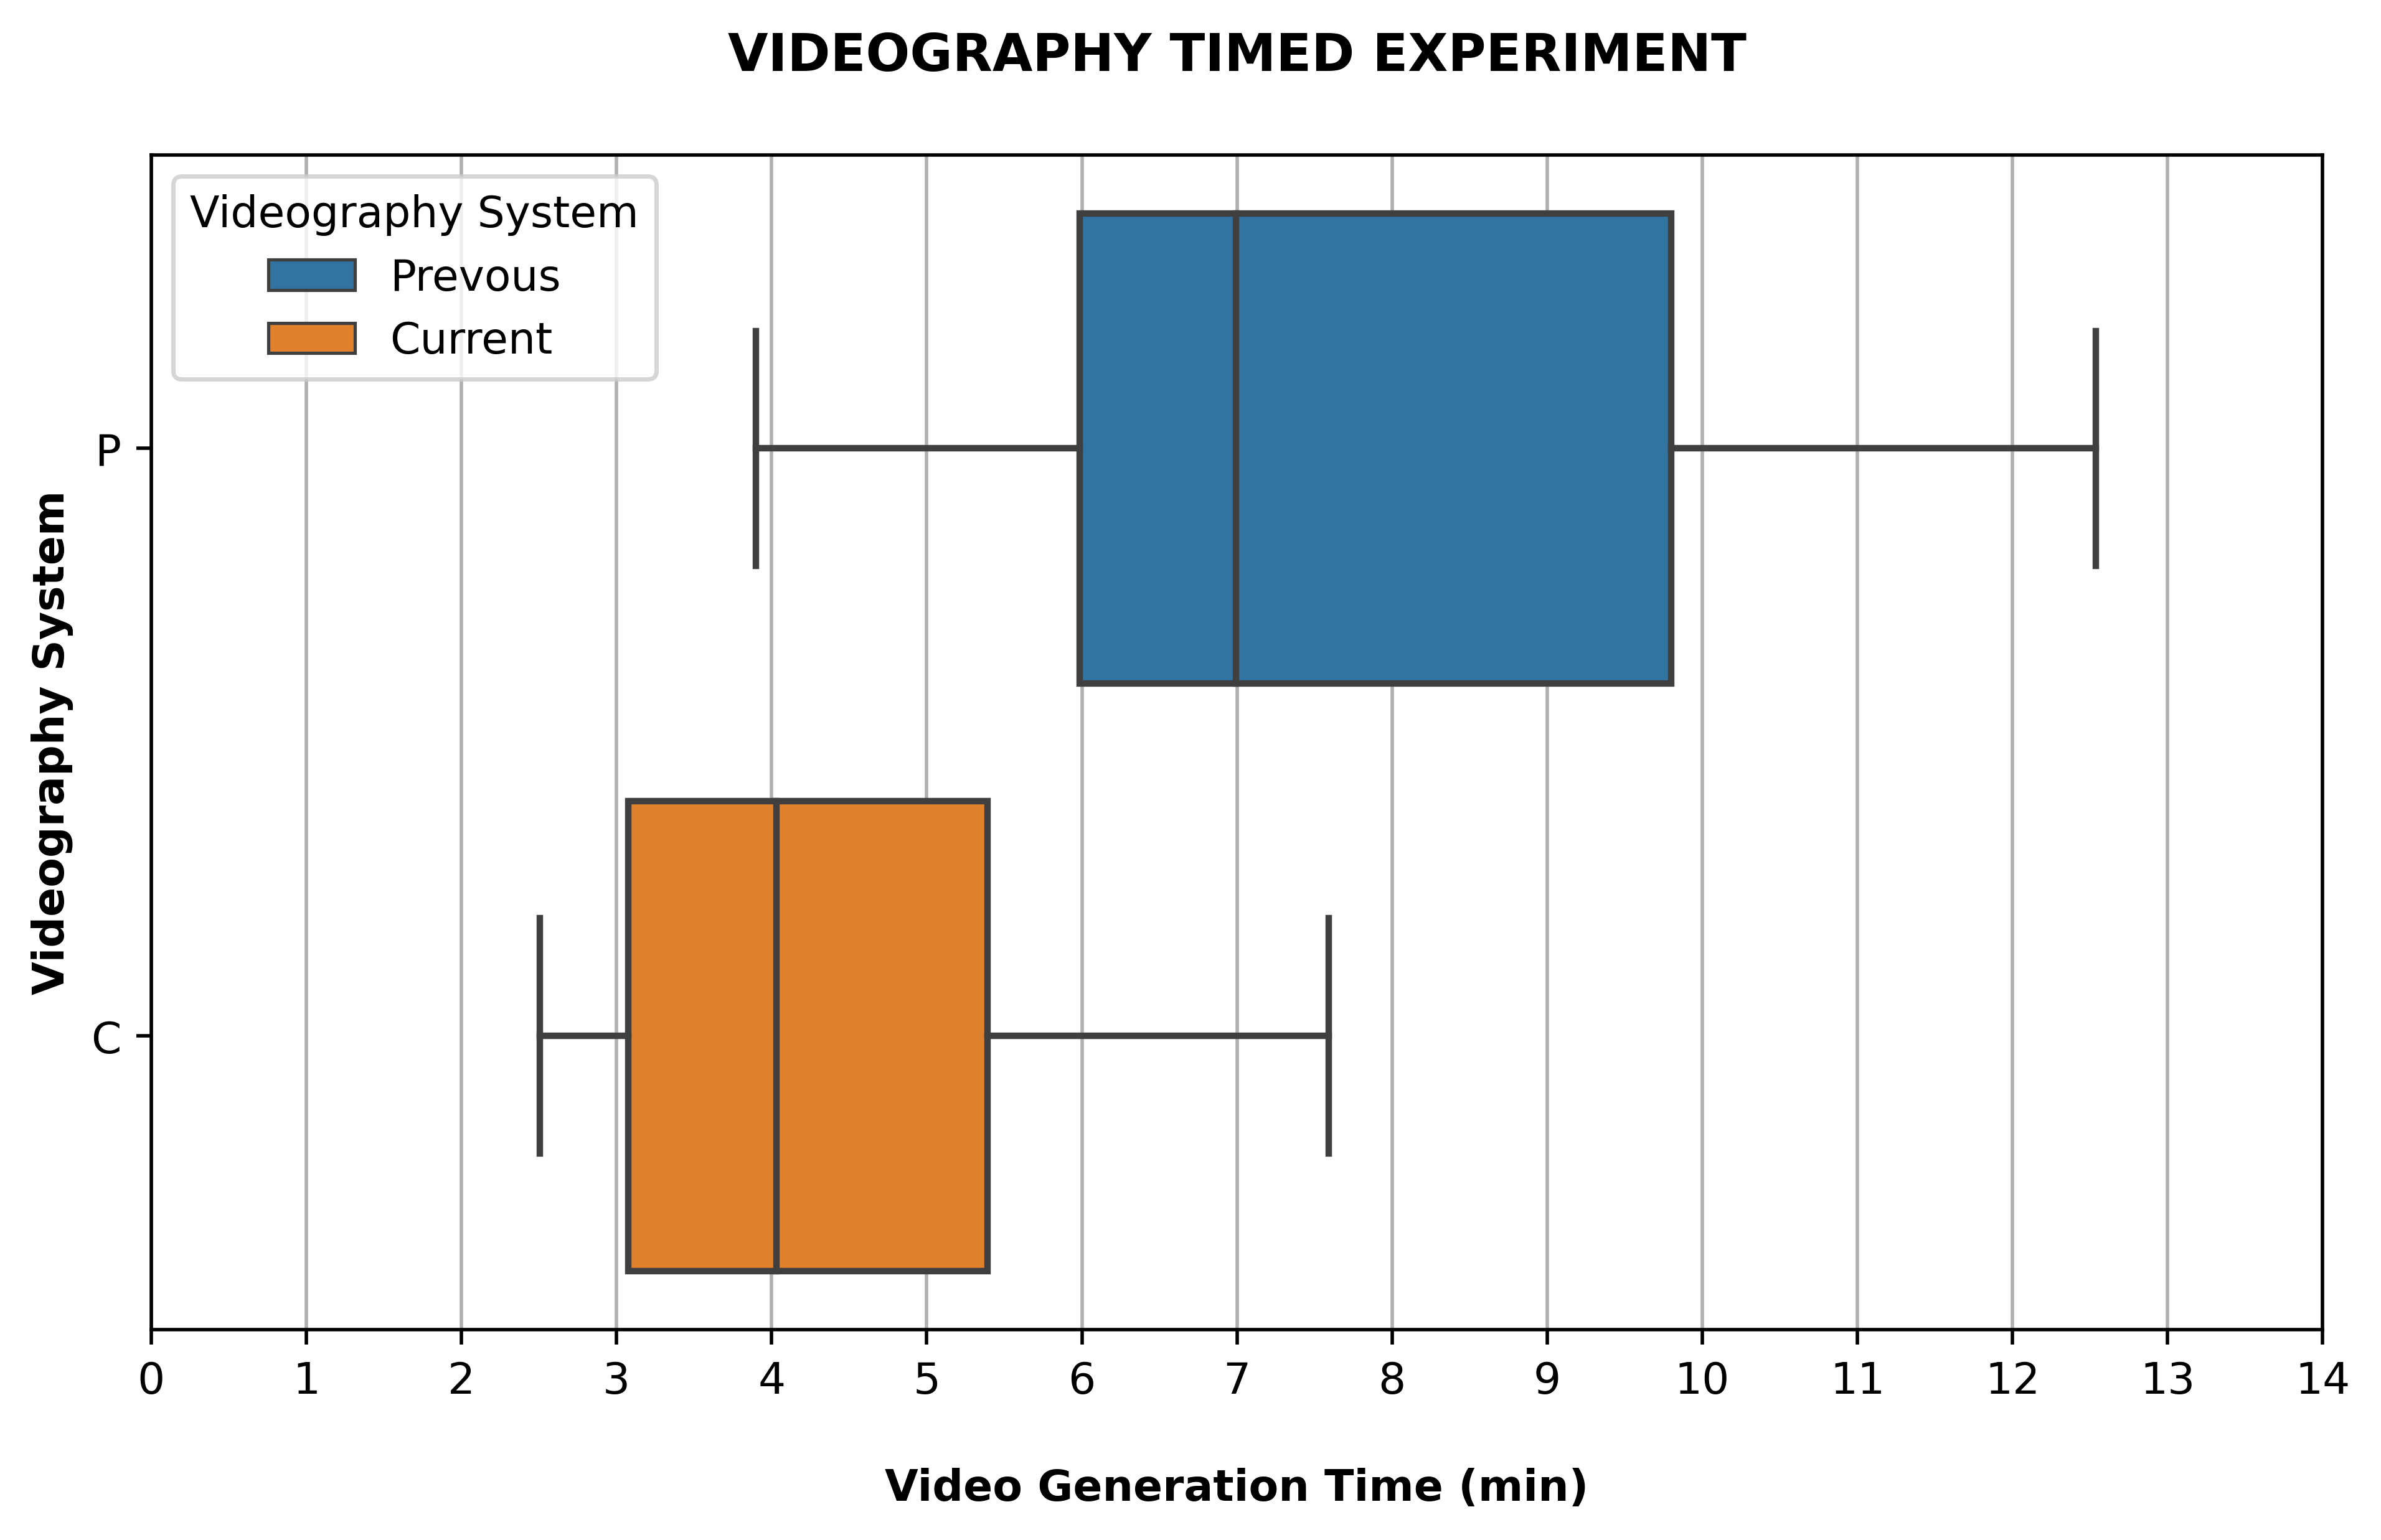

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gentimes = np.array([prev_gentimes / 60, generation_times / 60]).flatten()
df = pd.DataFrame({'gentimes': gentimes, 'Videography System': ['Prevous']*len(prev_gentimes)+['Current']*len(generation_times)})

fig = plt.figure(figsize=(9, 5), dpi=500)
sns.set_style({'axes.grid' : True})

ax = sns.boxplot(data=df, x="gentimes", y="Videography System", hue="Videography System", orient='h', dodge=False)
ax.set_title("VIDEOGRAPHY TIMED EXPERIMENT\n", fontweight="bold")
ax.set_xlabel("\nVideo Generation Time (min)", fontweight="bold")
ax.set_xticks(range(0, 16, 1))
ax.set_xlim(right=14)
ax.set_ylabel("Videography System", fontweight="bold")
ax.set_yticklabels(['P', 'C'])
ax.set_axisbelow(True)
plt.show()

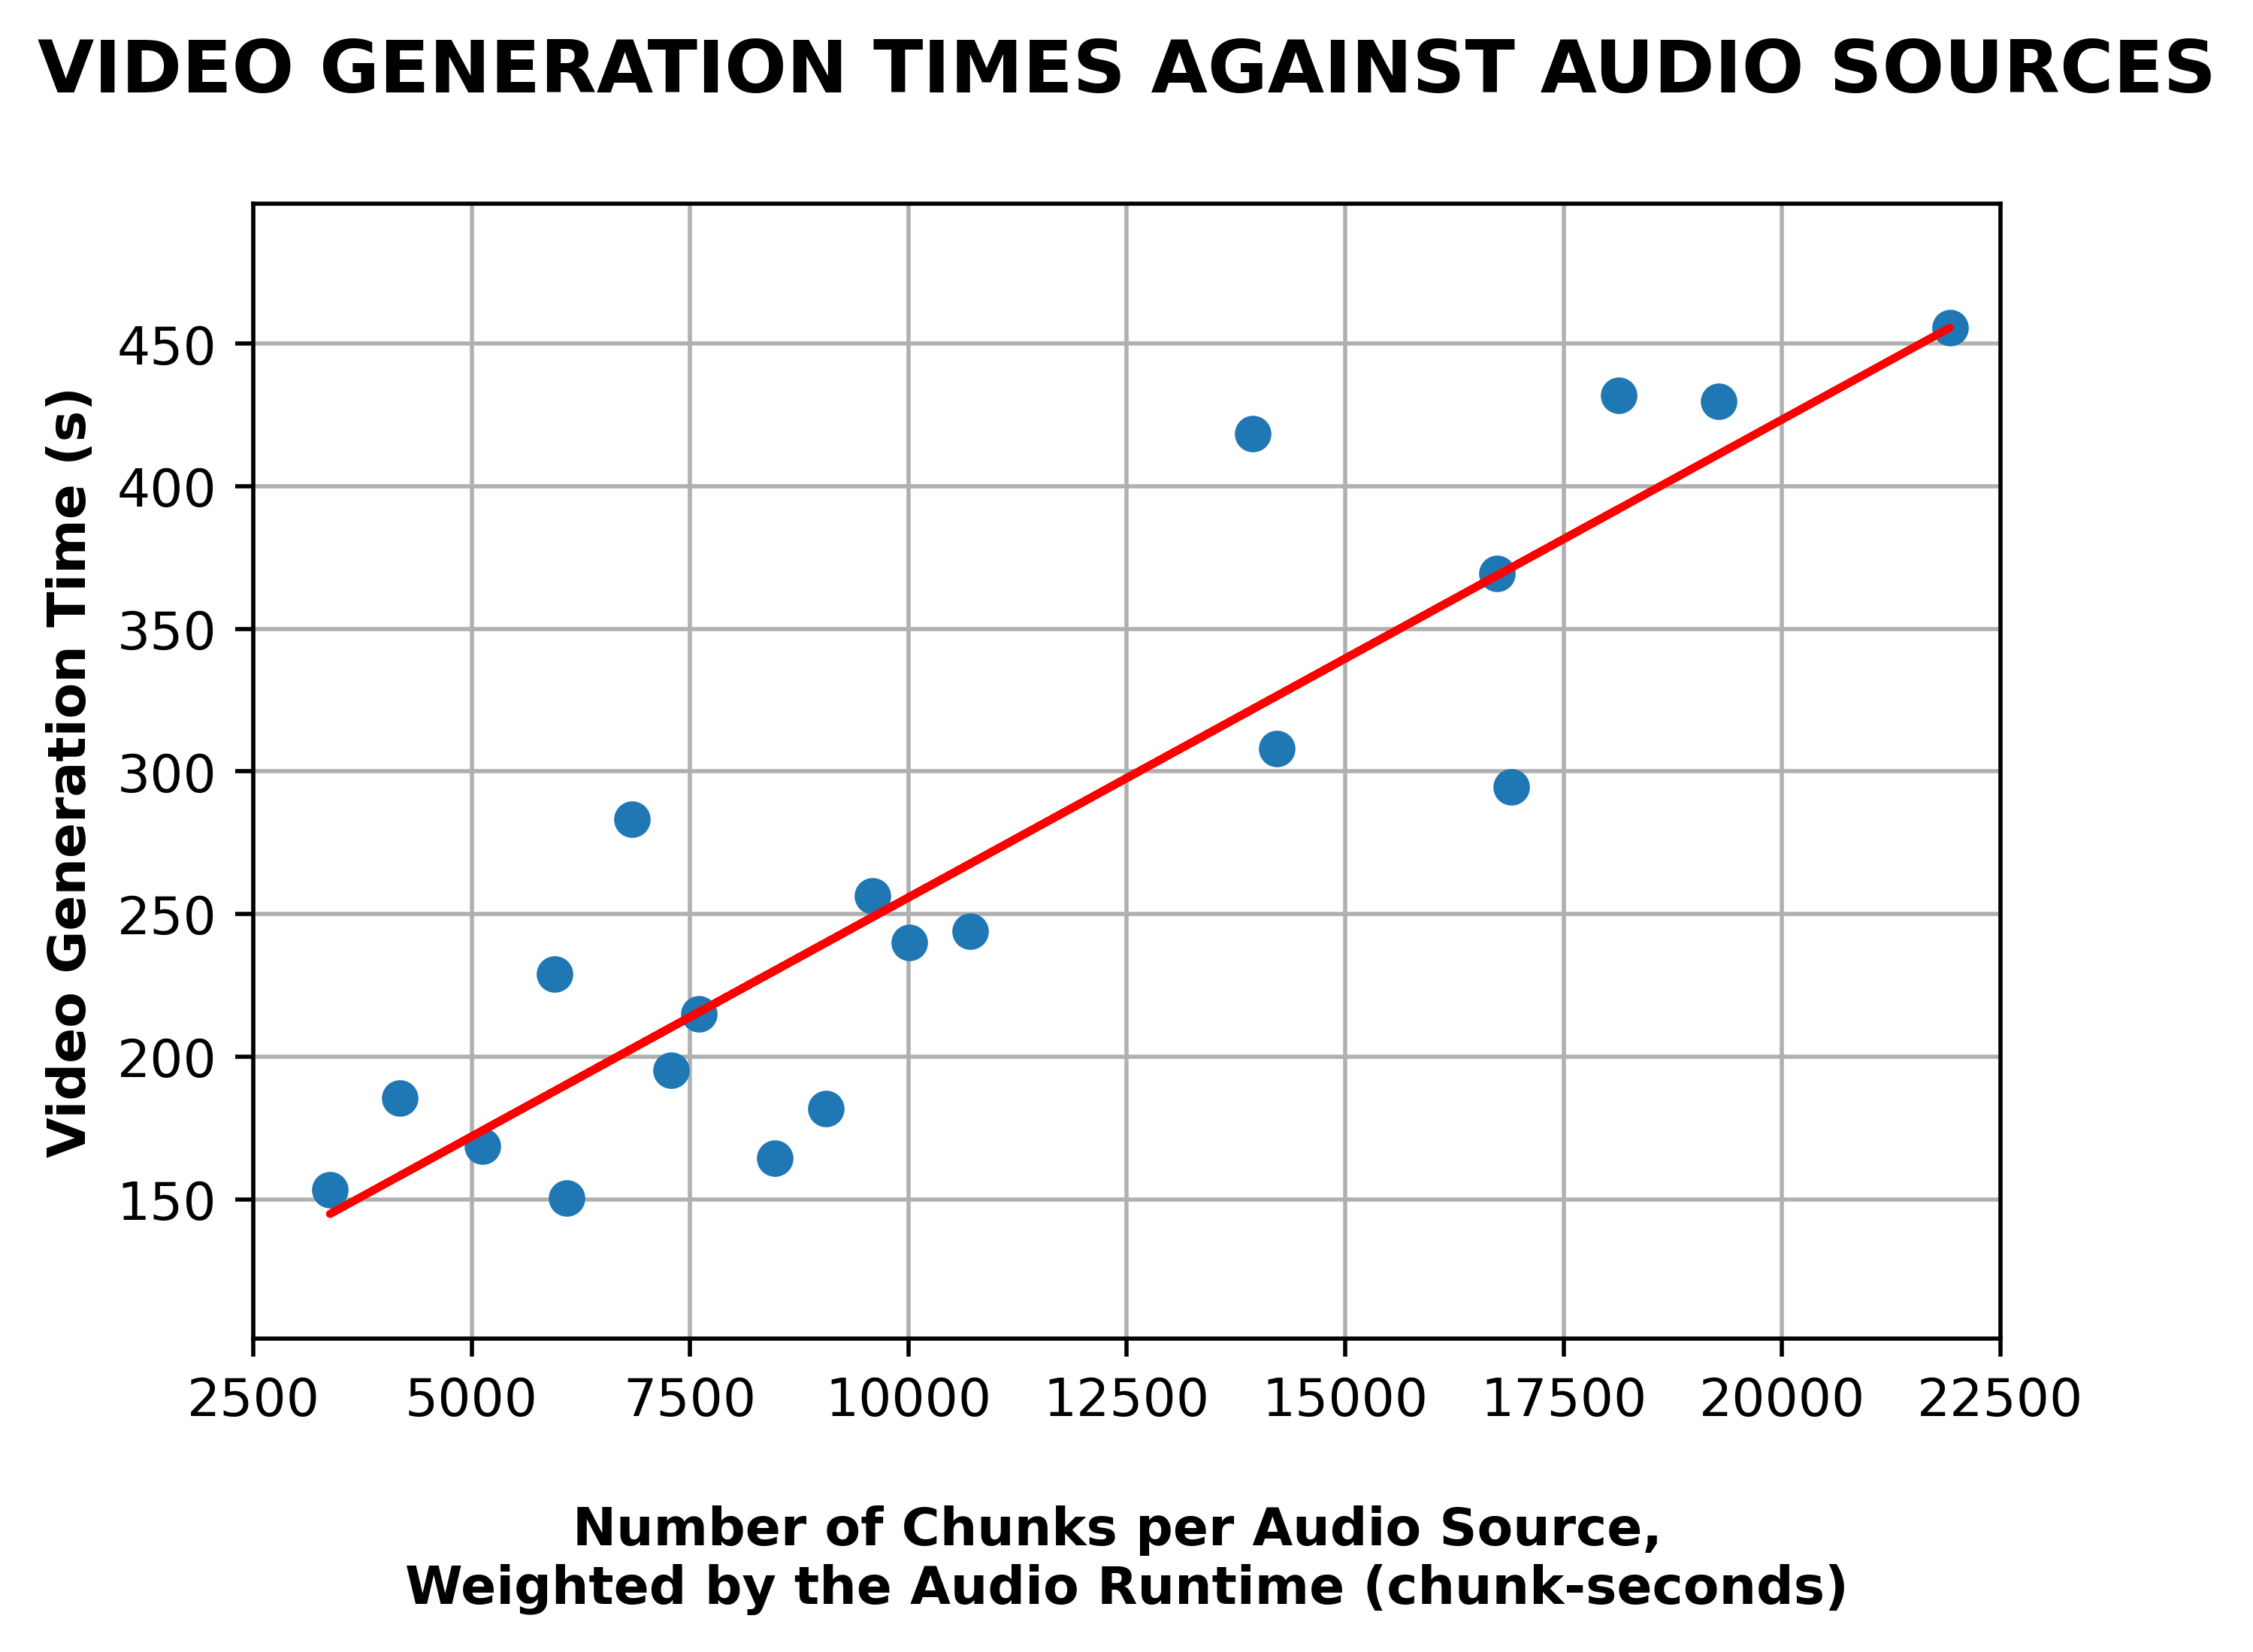

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), dpi=500)
ax = fig.add_subplot(1, 1, 1)

theta = np.polyfit(weighted_chunks, generation_times, 1)
bf_line = theta[0]*weighted_chunks + theta[1]
ax.plot(weighted_chunks, bf_line, 'r')
ax.scatter(weighted_chunks, generation_times)

ax.set_xlim(left=2500, right=22500)
ax.set_ylim(top=499, bottom=101)

ax.set_title("VIDEO GENERATION TIMES AGAINST AUDIO SOURCES\n", size=14, fontweight="bold")
ax.set_xlabel("\nNumber of Chunks per Audio Source, \nWeighted by the Audio Runtime (chunk-seconds)", fontweight="bold")
ax.set_ylabel("Video Generation Time (s)", fontweight="bold")
ax.grid(True)
ax.set_axisbelow(True)

In [328]:
for i, time in enumerate(runtimes):
    print(f"\\hline\n{i+1} & 0{to_time(time)[:-3]} & {chunks[i]} \\\\")

\hline
1 & 04:37 & 61 \\
\hline
2 & 02:25 & 42 \\
\hline
3 & 02:26 & 62 \\
\hline
4 & 03:58 & 81 \\
\hline
5 & 04:34 & 80 \\
\hline
6 & 04:30 & 62 \\
\hline
7 & 02:03 & 34 \\
\hline
8 & 03:10 & 36 \\
\hline
9 & 04:23 & 53 \\
\hline
10 & 03:26 & 69 \\
\hline
11 & 04:05 & 74 \\
\hline
12 & 03:08 & 51 \\
\hline
13 & 04:38 & 36 \\
\hline
14 & 04:04 & 21 \\
\hline
15 & 03:49 & 37 \\
\hline
16 & 03:20 & 38 \\
\hline
17 & 02:10 & 26 \\
\hline
18 & 04:09 & 43 \\
\hline
19 & 03:49 & 26 \\
\hline
20 & 04:40 & 26 \\


In [350]:
def to_time(seconds):
    return f"{int(seconds / 60):02d}:{seconds % 60:02.0f}"

for i, pgentime in enumerate(prev_gentimes):
    print(f"\\hline\n{i+1} & {to_time(pgentime)} & {to_time(generation_times[i])} \\\\")

\hline
1 & 08:47 & 04:55 \\
\hline
2 & 06:55 & 02:30 \\
\hline
3 & 09:48 & 03:02 \\
\hline
4 & 12:32 & 07:10 \\
\hline
5 & 12:24 & 07:36 \\
\hline
6 & 09:48 & 06:09 \\
\hline
7 & 05:46 & 03:05 \\
\hline
8 & 06:03 & 04:43 \\
\hline
9 & 08:30 & 06:58 \\
\hline
10 & 10:49 & 05:08 \\
\hline
11 & 11:32 & 07:12 \\
\hline
12 & 08:13 & 04:16 \\
\hline
13 & 06:03 & 03:60 \\
\hline
14 & 03:54 & 02:48 \\
\hline
15 & 06:12 & 02:44 \\
\hline
16 & 06:21 & 03:35 \\
\hline
17 & 04:37 & 02:33 \\
\hline
18 & 07:04 & 04:04 \\
\hline
19 & 04:37 & 03:49 \\
\hline
20 & 04:37 & 03:15 \\


In [110]:
# ps_times = [total_seconds("8:46.98")]
# chunk_rate = ps_times[0] / chunks[0]
# new_times = chunks[1:]*chunk_rate + random.uniform(50.0, 60.0)
# # new_times = chunks[1:]*chunk_rate
# ps_times.extend(new_times)
# ps_times = np.array(ps_times)

# print(ps_times)
# print(ps_times.mean() / 60)
# print(chunk_rate)
# print(np.array([to_time(secs) for secs in generation_times]))
# print(str(np.array([to_time(secs) for secs in ps_times])).replace("'", '"').replace(" ", ", "))
# print(ps_times.mean() / 60)

[526.98       415.27030751 588.05063537 752.19194685 743.55293046
 588.05063537 346.15817636 363.43620915 510.29948783 648.52375013
 691.7188321  493.02145505 363.43620915 233.85096324 372.07522554
 380.71424193 277.04604521 423.9093239  277.04604521 277.04604521]
7.7269820546338055
8.639016393442624
['4:54.50' '2:30.36' '3:01.68' '7:09.85' '7:35.59' '6:09.50' '3:05.48'
 '4:43.23' '6:58.38' '5:08.03' '7:11.92' '4:16.25' '3:59.90' '2:48.49'
 '2:44.49' '3:35.02' '2:33.38' '4:03.96' '3:48.91' '3:15.08']
["8:46.98", "6:55.27", "9:48.05", "12:32.19", "12:23.55", "9:48.05", "5:46.16"
, "6:03.44", "8:30.30", "10:48.52", "11:31.72", "8:13.02", "6:03.44", "3:53.85"
, "6:12.08", "6:20.71", "4:37.05", "7:03.91", "4:37.05", "4:37.05"]
7.7269820546338055
